# Basic Neuropixels Analysis

## Plotting firing rates and PCA

(1) In a text file (`mouse_config.txt`) define for each recording where all relevant data is located,
using the following format:

```
MOUSE: DL176
SL_PATH: /Volumes/T8/Data/Neuropixels/DL176/DL176_16_061322n3
NP_PATH: /Volumes/T8/Data/Neuropixels/DL176
TR_PATH: /Volumes/T8/Data/Neuropixels/DL176
KCUT: 0-660;8500-$
```

These lines specific for mouse DL176 that the sleep data in the folder after `SL_PATH:`. 
The files with all the firing rate information and histology alignment are in the folder `NP_PATH`. The ms spike trains are saved under the folder `TR_PATH`.
Using `KCUT:`, we can define time intervals that should be cut out from the recording. In this case, seconds 0-660 should be removed and the time interval from 8500s till the end of the recording (`$`). 

Under `EXCLUDE: ` you can exclude units for further analysis. 

Note: You can only remove intervals at the beginning of the end of the recording.

In [30]:
# Folder where 'mouse_config.txt' is located:
%load_ext autoreload
%autoreload 2

config_path = r'/Users/tortugar/My Drive/Penn/Programming/Neuropixels'
prog_path = '/Users/tortugar/My Drive/Penn/Programming/'
import os
import sys
sys.path.append(os.path.join(prog_path, 'Neuropixels'))
sys.path.append(os.path.join(prog_path, 'PySleep'))
import neuropyx as nx
import sleepy
import matplotlib.pylab as plt
import re

import warnings
warnings.filterwarnings('ignore')

# for interactive plots:
%matplotlib ipympl
plt.close('all')

config_file = os.path.join(config_path, 'mouse_config.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
mouse = 'JK353'
#mouse = 'J935'
mouse = 'JK382'
nsmooth = 1

# select only subregions for analysis?
restrict_regions=True
# select brain regions for analysis
br_regions = ['PL5', 'ILA5', 'ILA6a', 'DP', 'PL5']
br_regions = ['SSp-II1', 'SSP-II2/3']
br_regions =  ['MRN', 'INC', 'MRN', 'PAG']
#br_regions = ['PL5']
#br_regions = ['ILA5', 'ILA6a', 'DP']
#br_regions = ['ILA5', 'ILA6a', 'DP'] 


# load the units and further annotation (cell_info)
# M is the sleep annotation
# kcut specifies the intervals that have been cut
units, cell_info, M, kcut = nx.load_mouse(mouse, config_file)
nx.exclude_units(units, mouse, config_file)


if restrict_regions:
    ids = cell_info[cell_info.brain_region.isin(br_regions)]['ID']
    ids = [id for id in ids if re.match('.*_good$', id)]
    ids = [id for id in ids if id in list(units.columns)]
    units = units[ids]
else:
    ids = list(cell_info['ID'])
    ids = [i for i in ids if re.split('_', i)[1] == 'good']
    ids = [i for i in ids if i in list(units.columns)]

units = units[ids]
    

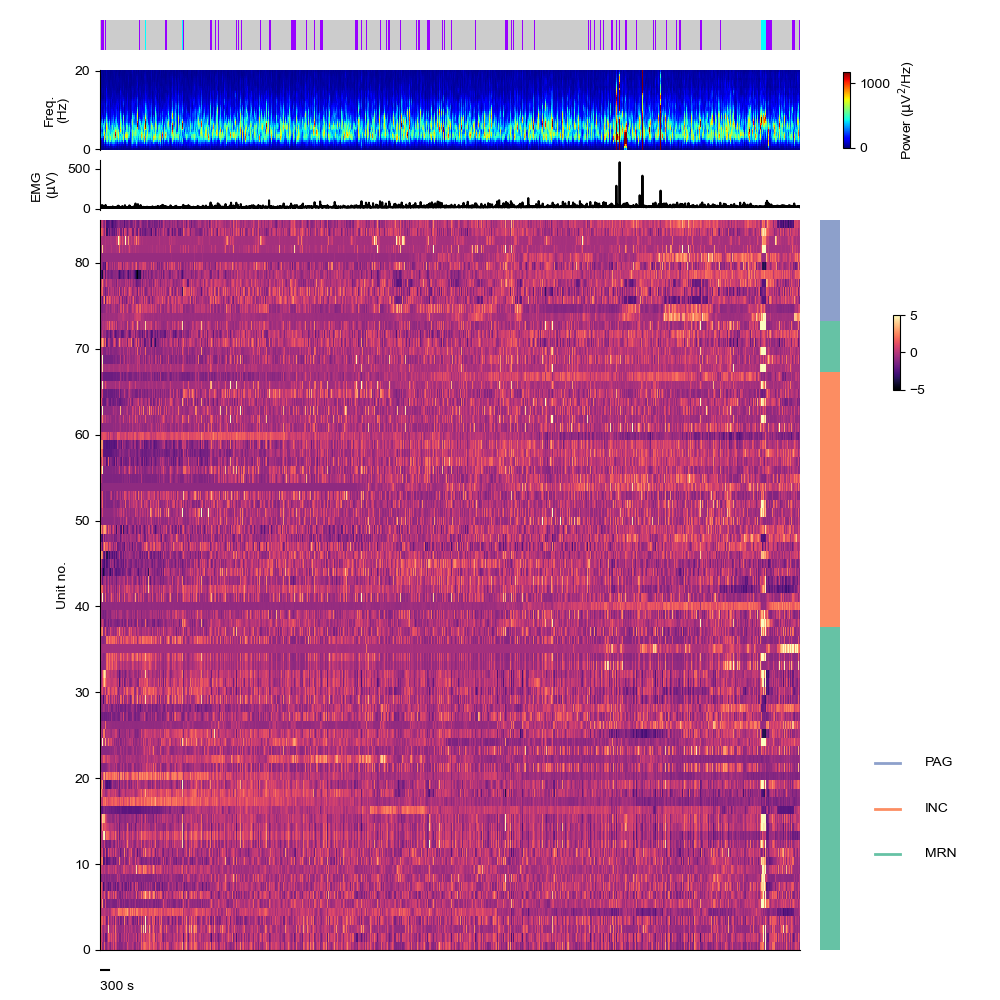

In [32]:
# plot all good units as heatmap
ids = list(cell_info['ID'])
ids = [i for i in ids if re.split('_', i)[1] == 'good']
ids = [i for i in ids if i in list(units.columns)]

r = nx.plot_firingrates_map(units, cell_info, ids, mouse, config_file, kcuts=[], pzscore=True, pregion=True,
                            nsmooth=1, pnorm_spec=False, box_filt=[3,4], vm_fr=[-5, 5], r_mu=[10,200])


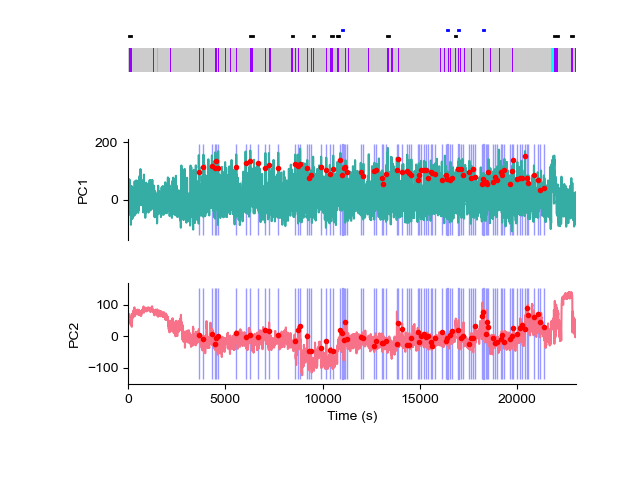

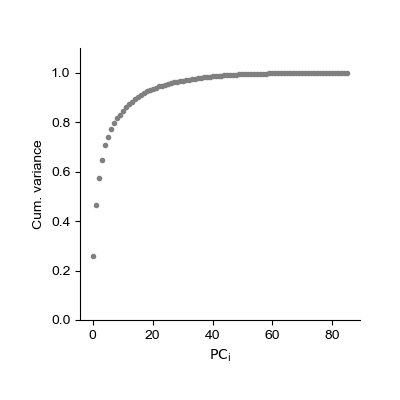

In [47]:
# Perform PCA of all units and plot (pplot=True) the first 2 (ndim=2) PCs. 
# Exclude long wake episodes;
# Z-score the data (pscore=True) and detrend firing rates (detrend=True), this can help if there's a slow 'linear' drift,
# shared by all units.

detrend = True
pc_sign = [1,-1]
PC, V, Vh, idx = nx.sleep_components(units, M, ndim=2, nsmooth=nsmooth, wake_dur=60, 
                                     pc_sign=pc_sign, pzscore=True, wake_break=20, 
                                     kcuts=kcut, detrend=detrend, ylim=[], mouse=mouse, config_file=config_file)

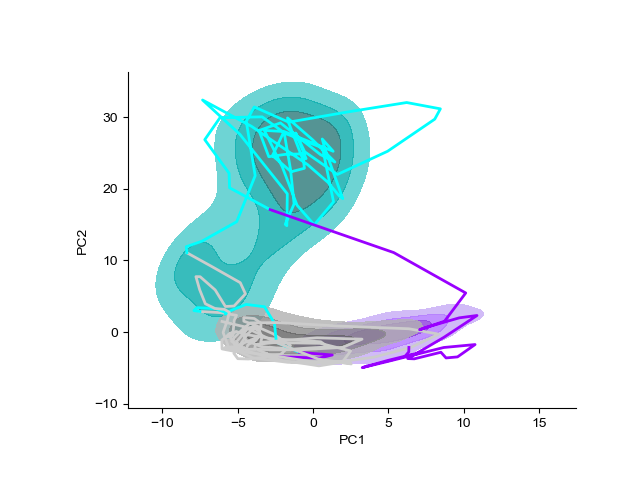

In [42]:
ma_thr=20
ax = nx.pc_state_space(PC[[0,1],:],M, ma_thr=ma_thr, ma_rem_exception=True,
                       pscatter=False, outline_std=False, break_out=False)[0]
nx.plot_trajectories(PC[[0,1],:], M, 120, 60, min_dur=20, istate=1, pre_state=3, 
                     state_num=[], ma_thr=ma_thr, kcuts=kcut, ax=ax, lw=2, ma_rem_exception=True)


Starting downsampling, smoothing and z-scoring


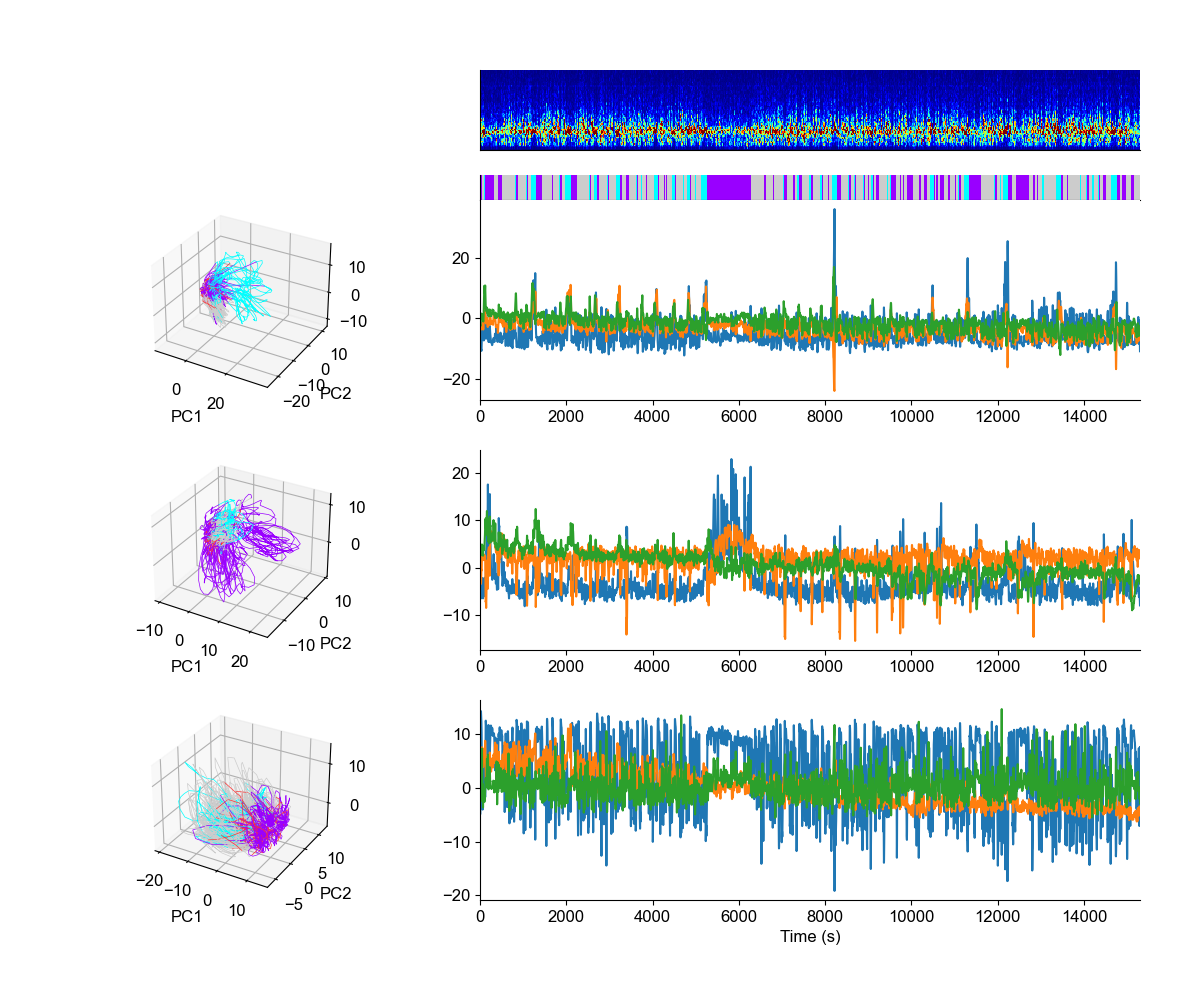

In [6]:
_=nx.sleep_subspaces(units, mouse, ndim=3, nsmooth=1.5, ma_thr=20, ma_rem_exception=False,
                    pzscore=True, detrend=False, pplot=True, coords=[], traj_mode='full', trig_state=1, 
                    local_rotation=False, pspec=True,
                    kcuts=[], proj_3d=True, config_file=config_file)

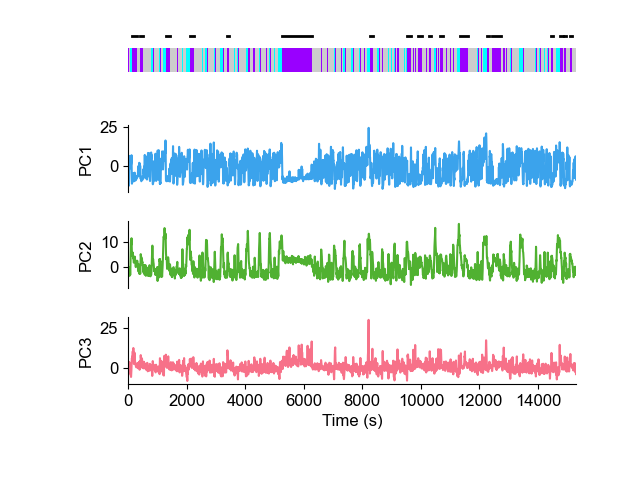

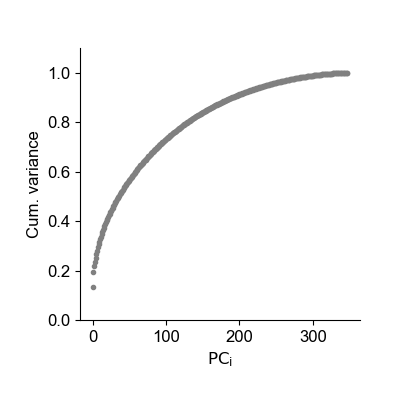

In [7]:
detrend = True
nsmooth = 1.5

PC_tmp, V, Vh, idx = nx.sleep_components(units, M, ndim=3, nsmooth=nsmooth, wake_dur=60, 
                                     pc_sign=[1,1,1], pzscore=True, wake_break=20, 
                                     kcuts=kcut, detrend=detrend, ylim=[], mouse=mouse, config_file=config_file, pplot=False)



# get corrected pc_sign
pc_sign = nx.align_pcsign(PC_tmp, mouse, config_file=config_file, kcuts=kcut)
pc_sign = [-1,-1]


# and then run again nx.sleep_components with the corrected parameters for pc_sign
PC, V, Vh, idx = nx.sleep_components(units, M, ndim=3, nsmooth=nsmooth, wake_dur=60, 
                                     pc_sign=pc_sign, pzscore=True, wake_break=20, 
                                     kcuts=kcut, detrend=detrend, ylim=[], mouse=mouse, config_file=config_file, pplot=True)

# reconstruction of firing rates using PCs
C, df, _, _ = nx.pc_reconstruction2(units, cell_info, time_idx=idx, ndim=3, nsmooth=nsmooth, 
                                    pnorm=False, pzscore=True, pearson=True,
                                    pc_sign=pc_sign, kcuts=kcut, detrend=detrend, pplot=False, sign_plot=False)


In [8]:
merged_df = df.merge(cell_info[['ID', 'brain_region', 'lateral']], on='ID', how='left')
merged_df['brain_region'].fillna('X', inplace=True)


<Axes: xlabel='c2', ylabel='Count'>

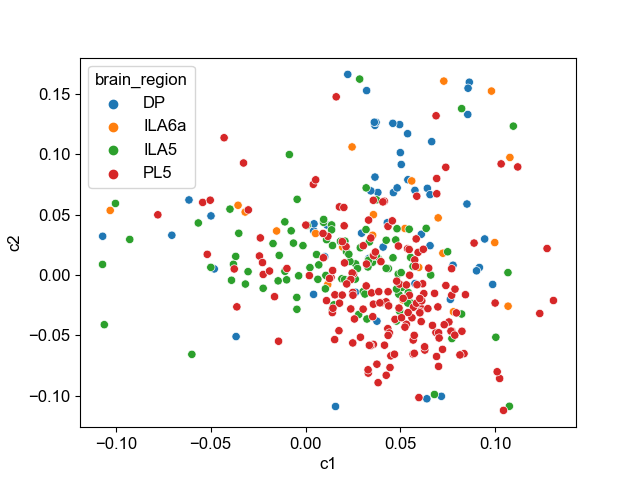

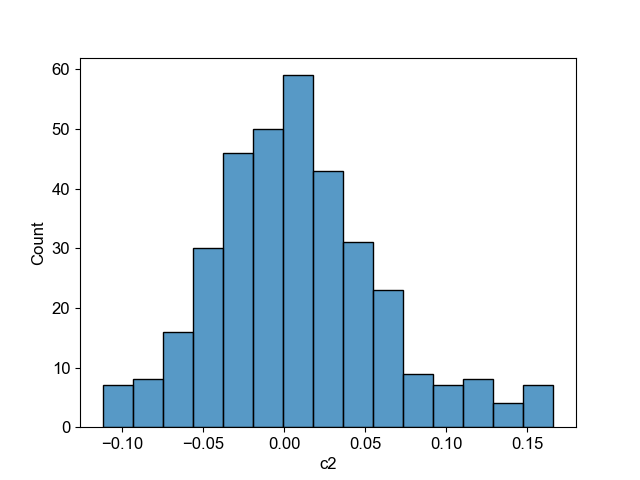

In [9]:
import seaborn as sns
plt.figure()
sns.scatterplot(data=merged_df, x='c1', y='c2', hue='brain_region')


plt.figure()
sns.histplot(data=df, x='c2', bins=15)

<Axes: xlabel='c2', ylabel='Density'>

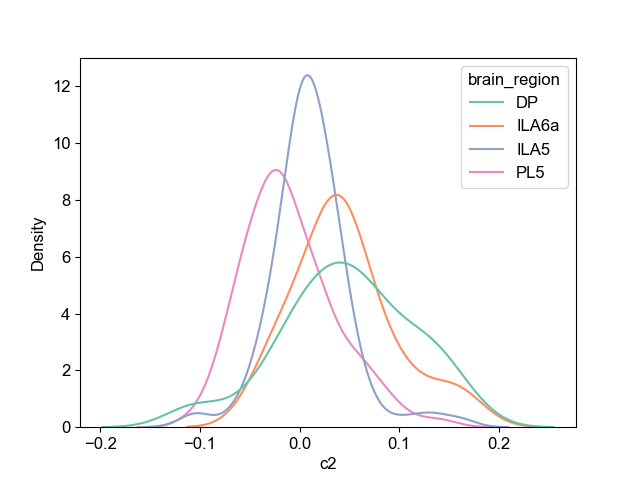

In [10]:
plt.figure()

sns.kdeplot(data=merged_df, x='c2', hue='brain_region', common_norm=False, palette='Set2')


,mouse,freq,pow,typ
0,JK382,0.000000,0.898765,Spec
1,JK382,0.003125,1.894806,Spec
2,JK382,0.006250,1.420699,Spec
3,JK382,0.009375,1.528826,Spec
4,JK382,0.012500,3.424667,Spec
...,...,...,...,...
190,JK382,0.187500,0.004620,PC2
191,JK382,0.190625,0.005303,PC2
192,JK382,0.193750,0.003413,PC2
193,JK382,0.196875,0.003443,PC2


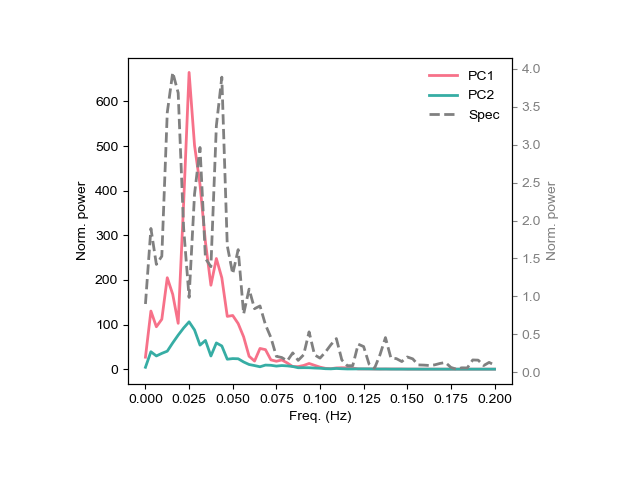

In [38]:

#idx = range(0, 1500)
idx = range(6000, 7500)
nx.pc_infraslow(PC[:,idx], M[idx], mouse, kcuts=(), dt=2.5, nsmooth=0, ma_thr=20, 
                 ma_rem_exception=False, ma_mode=True, kcut=[], state=3, peeg2=False,
                 band=[10,15], min_dur=120, win=128, config_file=config_file, 
                 pnorm=False, spec_norm=True, spec_filt=False, box=[1,4], pplot=True)

In [43]:
df = nx.laser_triggered_frs(units[ids], 30, 20, mouse, ma_thr=10, ma_rem_exception=True,
                        pzscore=True, nsmooth=0, detrend=True, min_laser=1,
                        config_file=config_file)

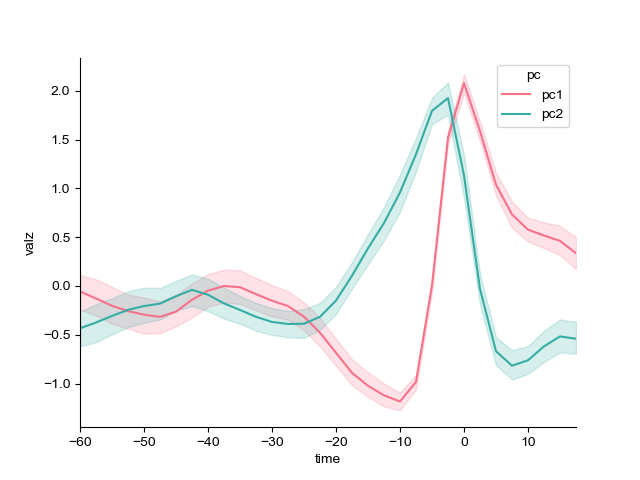

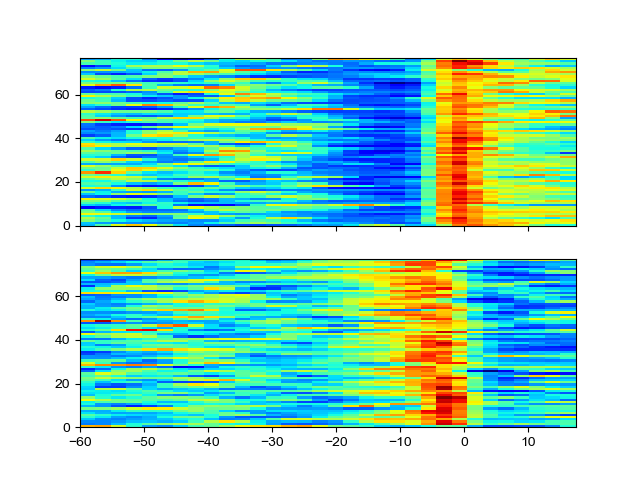

In [45]:
_=nx.laser_triggered_pcs(PC[0:2,:], 60, 20, M, mouse, kcuts=[], min_laser=0.1, pzscore_pc=False, config_file=config_file)

In [ ]:
ids_sel = cell_info[cell_info.brain_region.isin(['PL5'])].ID
ids_sel = [i for i in ids_sel if re.split('_', i)[1]=='good']

ids_sel2 = cell_info[cell_info.brain_region.isin(['ILA5'])].ID
ids_sel2 = [i for i in ids_sel2 if re.split('_', i)[1]=='good']


In [ ]:
A = np.array(units.loc[:,ids_sel])
B = np.array(units.loc[:,ids_sel2])

In [ ]:
fig, axs= plt.subplots(2,1, sharex=True)
axs[0].plot(M)
axs[1].plot(sleepy.smooth_data(A.mean(axis=1),2))
axs[1].plot(sleepy.smooth_data(B.mean(axis=1),2))

In [ ]:
import numpy as np
fr = np.array(units).T

In [ ]:
c2 = np.array(df['c2'])

In [ ]:
idx = np.argsort(c2)

In [ ]:
plt.figure()
ax = plt.subplot(111)
plt.plot(sleepy.smooth_data(fr[idx,:][3,:].T, 2))
plt.plot(sleepy.smooth_data(fr[idx,:][-1,:].T, 2))
plt.plot(M)

In [ ]:
fr.shape

In [ ]:
c2[idx]

In [17]:
import numpy as np

raster = np.array(units).T

ii = []
for i in range(raster.shape[0]):
    m = raster[i,:].mean()
    
    if m > 5:
        ii.append(i)



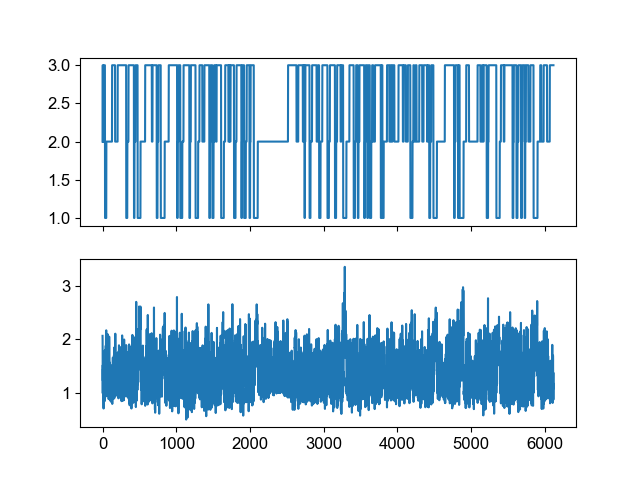

In [21]:
fig,axs = plt.subplots(2,1, sharex=True)
axs[1].plot(raster[:,:].mean(axis=0))
axs[0].plot(M)

In [19]:
len(ii)

22